In [23]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [24]:
import agent_class as agent

# Создание среды

In [25]:
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env, reward_params):
        super().__init__(env)
        self.reward_params = reward_params

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        reward = self.reward_fast_and_accurate(observation, reward, terminated, truncated, info)
        return observation, reward, terminated, truncated, info

    def custom_reward(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation
        distance_reward = -abs(x) * self.reward_params['distance_penalty']
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']
        velocity_reward = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']
        reward += distance_reward + angle_penalty + velocity_reward
        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus']
        return reward
    
    def reward_survive_and_be_accurate(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation
        distance_reward = -abs(x) * self.reward_params['distance_penalty']
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']
        velocity_penalty = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']

        reward += distance_reward + angle_penalty + velocity_penalty

        if terminated:
            if reward > 0:
                reward += self.reward_params['landing_bonus']
            else:
                reward -= self.reward_params['landing_bonus']
        elif truncated:
            reward -= self.reward_params['landing_bonus'] / 2
        else:
            reward += 0.1
        return reward
    
    def reward_fast_and_accurate(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation
        distance_reward = -abs(x) ** 2 * self.reward_params['distance_penalty']  # Квадратичный штраф за расстояние
        angle_penalty = -abs(angle) ** 2 * self.reward_params['angle_penalty']  # Квадратичный штраф за угол
        velocity_reward = -(abs(vx) + abs(vy)) ** 2 * self.reward_params['velocity_penalty'] # Квадратичный штраф за скорость

        reward += distance_reward + angle_penalty + velocity_reward

        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus'] * 2  # Большой бонус за успешную посадку
        elif terminated:
            reward -= self.reward_params['landing_bonus'] * 2 # Большой штраф за падение
        elif truncated:
            reward -= self.reward_params['landing_bonus']

        return reward
    
    def reward_based_on_height(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation

        # Штраф за расстояние
        distance_reward = -abs(x) * self.reward_params['distance_penalty']

        # Угол
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']

        # Скорость
        velocity_penalty = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']

        reward += distance_reward + angle_penalty + velocity_penalty


        # Поощряем снижение скорости при приближении к земле
        if y < 50:  # Например, на высоте меньше 50 метров
            reward += -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty'] * 2 # Удваиваем штраф за скорость,чтобы замедлиться

        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus']
        elif terminated:
            reward -= self.reward_params['landing_bonus']

        elif truncated:
            reward -= self.reward_params['landing_bonus'] / 2

        return reward
    
    def reward_sparse(self, observation, reward, terminated, truncated, info):
        if terminated and reward > 0:
            reward = self.reward_params['landing_bonus']  # Только бонус за успешную посадку
        elif terminated:
            reward = -self.reward_params['landing_bonus'] # Штраф за падение
        elif truncated:
            reward = -self.reward_params['landing_bonus'] / 2
        else:
            reward = -0.1 #небольшой штраф за каждый шаг

        return reward
    
    def reward_action_dependent(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation

        distance_reward = -abs(x) * self.reward_params['distance_penalty']
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']
        velocity_penalty = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']
        reward += distance_reward + angle_penalty + velocity_penalty

        try:
            action = info['action']  # Предполагаем, что 'action' есть в info
            # Пример: Штрафуем за слишком большую тягу (предполагаем, что action - это значение тяги)
            if abs(action) > 0.8:
                reward -= 0.05 # Штраф

        except KeyError:
            print("Предупреждение: Информация о действии отсутствует в 'info'.")

        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus']
        elif terminated:
            reward -= self.reward_params['landing_bonus']
        elif truncated:
            reward -= self.reward_params['landing_bonus'] / 2

        return reward

reward_params = {
    'distance_penalty': 0.1,
    'angle_penalty': 0.1,
    'velocity_penalty': 0.01,
    'landing_bonus': 100.0
}

env = gym.make('LunarLander-v3')
env = CustomRewardWrapper(env, reward_params)  # Оборачиваем среду

N_actions = env.action_space.n
observation, info = env.reset()
N_state = len(observation)

print('dimension of state space =',N_state)
print('number of actions =',N_actions)

env = gym.make('LunarLander-v3')
env = CustomRewardWrapper(env, reward_params)  # Оборачиваем среду и здесь!
print('dimension of state space =',N_state)
print('number of actions =',N_actions) #

dimension of state space = 8
number of actions = 4
dimension of state space = 8
number of actions = 4


In [26]:
parameters = {'N_state':N_state, 'N_actions':N_actions}
my_agent = agent.dqn(parameters=parameters)


# Train agent

In [27]:
training_results = my_agent.train(environment=env,
                                verbose=True)


| episode | return          | minimal return      | mean return        |
|         | (this episode)  | (last 20 episodes)  | (last 20 episodes) |
|-----------------------------------------------------------------------
|     100 |     -634.134    |       -634.134      |      -363.887      |
|     200 |     -321.020    |       -469.630      |      -364.178      |
|     300 |     -499.190    |       -722.860      |      -336.516      |
|     400 |     -232.514    |       -476.014      |      -296.722      |
|     500 |     -274.956    |       -474.178      |      -199.371      |
|     600 |     -243.847    |       -288.650      |        20.901      |
|     700 |      -45.027    |       -369.123      |      -121.703      |
|     779 |      433.400    |        360.326      |       436.154      |


In [28]:
training_results.keys()

dict_keys(['episode_durations', 'epsiode_returns', 'n_training_epochs', 'n_steps_simulated', 'training_completed'])

# Отображение обучения агента

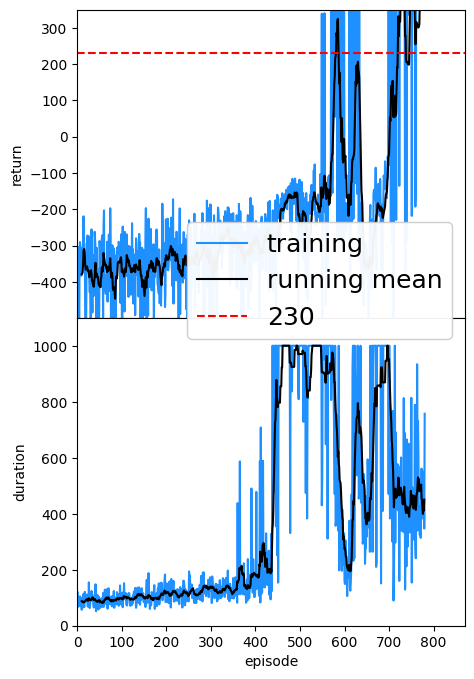

In [29]:
N = 10

def running_mean(x,N=20):
        x_out = np.zeros(len(x)-N,dtype=float)
        for i in range(len(x)-N):
                x_out[i] = np.mean(x[i:i+N+1])
        return x_out
        
def plot_returns_and_durations(training_results,filename=None):
    fig,axes = plt.subplots(2,1,figsize=(5,8))
    fig.subplots_adjust(hspace=0.0001)
    #
    # return as a function of episode
    ax = axes[0]
    x = training_results['epsiode_returns']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(230,ls='--',
               label='230',
                        color='red')
    #
    ax.set_ylim(-499,350)
    ax.set_xticks([])
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel('episode')
    ax.set_ylabel('return')
    #
    #
    ax = axes[1]
    x = training_results['episode_durations']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(1200,ls='--', # draw line outside of plot scale, 
                label='230', # to get the red dotted line into the legend
                        color='red')
    #
    ax.set_ylim(0,1100)
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel('episode')
    ax.set_ylabel('duration')
    ax.legend(loc='upper right',bbox_to_anchor=(1.,1.35),
                                framealpha=0.95,
                        fontsize=18)
    #
    plt.show()
    if filename != None:
        fig.savefig(filename,bbox_inches='tight')
    plt.close(fig)

plot_returns_and_durations(training_results=training_results)

# Создание видео используя обученного агента




In [30]:
class PyGameWrapper(gym.Wrapper):
    def render(self, **kwargs):
        retval = self.env.render( **kwargs)
        for event in pygame.event.get():
            pass
        return retval

In [31]:
# Create a wrapped environment
env = PyGameWrapper(gym.make('LunarLander-v3',render_mode='human'))

N_episodes = 20

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        #env.render()

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break
    
env.close()

Run 1: duration = 299, total return = 280.947
Run 2: duration = 297, total return = 273.937
Run 3: duration = 848, total return = 265.212
Run 4: duration = 310, total return = 250.393
Run 5: duration = 276, total return = 282.698
Run 6: duration = 709, total return = 249.144
Run 7: duration = 216, total return =  15.757
Run 8: duration = 239, total return =  33.145
Run 9: duration = 319, total return =  17.573
Run 10: duration = 199, total return =  53.601
Run 11: duration = 1000, total return = 131.405
Run 12: duration = 280, total return = 267.446
Run 13: duration = 1000, total return = 148.976
Run 14: duration = 323, total return = 246.732
Run 15: duration = 1000, total return = 145.047
Run 16: duration = 336, total return = 245.869
Run 17: duration = 1000, total return = 143.304
Run 18: duration = 272, total return = 282.484
Run 19: duration = 309, total return = 230.212
Run 20: duration = 311, total return = 232.401


We also create a video file containing 20 games played by the agent

In [32]:
from gymnasium.wrappers import RecordVideo
import itertools

env = gym.make('LunarLander-v3', render_mode="rgb_array")
env = RecordVideo(env, './video', episode_trigger = lambda episode_id: True) # Records every episode

N_episodes = 20

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        # No need for video.capture_frame() with RecordVideo

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break

env.close()

/home/ubersmurfx/.local/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/ubersmurfx/poly2025-2026/lunar-lander/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Run 1: duration = 272, total return = 268.852
Run 2: duration = 313, total return = 257.392
Run 3: duration = 221, total return =  47.695
Run 4: duration = 268, total return = 254.955
Run 5: duration = 305, total return = 250.870
Run 6: duration = 314, total return = 231.622
Run 7: duration = 275, total return = 284.899
Run 8: duration = 333, total return = 247.306
Run 9: duration = 286, total return = 259.871
Run 10: duration = 308, total return = 279.436
Run 11: duration = 311, total return = 256.802
Run 12: duration = 293, total return = 231.631
Run 13: duration = 1000, total return = 140.647
Run 14: duration = 345, total return = 246.109
Run 15: duration = 349, total return = 257.651
Run 16: duration = 303, total return = 243.151
Run 17: duration = 211, total return =  28.791
Run 18: duration = 236, total return =  38.603


KeyboardInterrupt: 